# Yelp Dataset Challenge
https://www.yelp.com/dataset/challenge

Introduction: 

Natural Language Processing & Sentiment Analysis
What's in a review? Is it positive or negative? Yelp reviews contain a lot of metadata that can be mined and used to infer meaning, business attributes, and sentiment.

In [1]:
# Import Libraries
import json
import os

import numpy as np
import pandas as pd
import string
from string import digits
import re
import tensorflow as tf
from tensorflow import keras

from numpy.random import seed
seed(2)
from tensorflow import set_random_seed
set_random_seed(2)

import matplotlib.pyplot as plt
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Bidirectional
from keras.layers import Input

Using TensorFlow backend.


## Step 1: Extract and Import Data

In [2]:
# Load the json file downloaded from Yelp Dataset
tweets = []
for line in open('review.json', 'r', encoding='utf-8'):
    tweets.append(json.loads(line))

In [ ]:
# Convert data from the json file into a dataframe
from tqdm import tqdm

data = { 'business_id': [], 'stars':[], 'text': []  }

with open('review.json',encoding='utf-8' ) as f:
    for line in tqdm(f):
        review = json.loads(line)
        data['business_id'].append(review['business_id'])
        data['stars'].append(review['stars'])
        data['text'].append(review['text'])
        
df = pd.DataFrame(data)

In [ ]:
# Extra the first 250k lines of reviews and export them into a csv file
yelp_review=df[:250000]
export_csv=yelp_review.to_csv('yelp_review_250k.csv', header=True) 

## Step 2: Data Preprocessing

In [3]:
# Import the cvs file and read it as dataframe.
new_df=pd.read_csv('yelp_review_250k.csv')
new_df.head()

# Randomly shuffle the data 
new_df= new_df.reindex(np.random.permutation(new_df.index))
new_df.head()

,Unnamed: 0,business_id,stars,text
221576,221576,2W3If040rgz34_ZO3c_SxA,1.0,Terrible service. The wait time is horrendousl...
62935,62935,-1xuC540Nycht_iWFeJ-dw,5.0,I felt like I was joining a club. There are ru...
53216,53216,XrpWb4vB7-1z26OreeCD2w,4.0,"Pleasant staff, great food. Not too much for v..."
128428,128428,3I0Psc6hb4kwOV4TlS03hw,1.0,If I could I would leave no stars. The night t...
30376,30376,CgsUUVwL8EBqcHFxrtkFtA,2.0,The waitress was very pleasant but didn't do a...


In [4]:
# Filter out the index column 
new_df=new_df[['business_id', 'stars','text']]
new_df.head()

,business_id,stars,text
221576,2W3If040rgz34_ZO3c_SxA,1.0,Terrible service. The wait time is horrendousl...
62935,-1xuC540Nycht_iWFeJ-dw,5.0,I felt like I was joining a club. There are ru...
53216,XrpWb4vB7-1z26OreeCD2w,4.0,"Pleasant staff, great food. Not too much for v..."
128428,3I0Psc6hb4kwOV4TlS03hw,1.0,If I could I would leave no stars. The night t...
30376,CgsUUVwL8EBqcHFxrtkFtA,2.0,The waitress was very pleasant but didn't do a...


In [5]:
# Create a new column called “label” to identify negative (0) , neutral (1) , and positive (2) reviews
new_df.loc[new_df.stars==1, 'label']=0
new_df.loc[new_df.stars==2, 'label']=0
new_df.loc[new_df.stars==3, 'label']=1
new_df.loc[new_df.stars==4, 'label']=2
new_df.loc[new_df.stars==5, 'label']=2

In [6]:
# Inspect the data to ensure that labels are properly coded
new_df.head()

,business_id,stars,text,label
221576,2W3If040rgz34_ZO3c_SxA,1.0,Terrible service. The wait time is horrendousl...,0.0
62935,-1xuC540Nycht_iWFeJ-dw,5.0,I felt like I was joining a club. There are ru...,2.0
53216,XrpWb4vB7-1z26OreeCD2w,4.0,"Pleasant staff, great food. Not too much for v...",2.0
128428,3I0Psc6hb4kwOV4TlS03hw,1.0,If I could I would leave no stars. The night t...,0.0
30376,CgsUUVwL8EBqcHFxrtkFtA,2.0,The waitress was very pleasant but didn't do a...,0.0


In [50]:
# Check whether there are any missing data
new_df.isnull().sum()

business_id    0
stars          0
text           0
label          0
dtype: int64

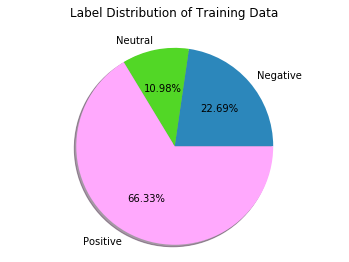

In [51]:
#inspect the distribution of training labels before converting the data into one-hot encoding
train_label_dist = new_df.label[:200000]
ytrain_label, ytrain_count=np.unique(train_label_dist, return_counts=True)
ytrain_label, ytrain_count
label_list=['Negative', 'Neutral','Positive']

colors = ['#2c87bb', '#52d726', '#ffa9fd']
fig1, ax1 = plt.subplots() 
ax1.pie(ytrain_count, labels=label_list,colors=colors,autopct='%.2f%%',pctdistance = 0.6,  
        shadow=True, startangle=0)
ax1.axis('equal')
plt.title('Label Distribution of Training Data\n')
plt.show()

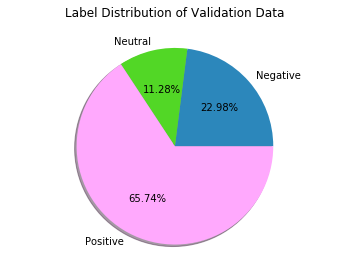

In [52]:
#inspect the distribution of validation labels before converting the data into one-hot encoding
val_label_dist = new_df.label[200000:]
yval_label, yval_count=np.unique(val_label_dist, return_counts=True)
yval_label, yval_count
label_list=['Negative', 'Neutral','Positive']


fig2, ax2 = plt.subplots() 
ax2.pie(yval_count, labels=label_list,colors=colors,autopct='%.2f%%',pctdistance = 0.6,  
        shadow=True, startangle=0)
ax2.axis('equal')  
plt.title('Label Distribution of Validation Data\n')
plt.show()

In [7]:
# Format the “text” column to turn all words into lowercase letters
new_df.text=new_df.text.apply(lambda x: x.lower())

In [8]:
# Format “text” column to exclude all punctuations
exclude = set(string.punctuation)
new_df.text=new_df.text.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))


In [9]:
# Format “text” column to exclude all numbers
remove_digits = str.maketrans('', '', digits)
new_df.text=new_df.text.apply(lambda x: x.translate(remove_digits))

In [10]:
# Format “text” column to remove any extra spaces before and after a paragraph 
new_df.text=new_df.text.apply(lambda x: x.strip())

In [11]:
# Format “text” column to remove line separators (\n)
new_df.text=new_df.text.apply(lambda x: re.sub("\n", '', x))

In [12]:
# Inspect data to ensure that the "text" column has been formatted properly 
new_df.head()

,business_id,stars,text,label
221576,2W3If040rgz34_ZO3c_SxA,1.0,terrible service the wait time is horrendously...,0.0
62935,-1xuC540Nycht_iWFeJ-dw,5.0,i felt like i was joining a club there are rul...,2.0
53216,XrpWb4vB7-1z26OreeCD2w,4.0,pleasant staff great food not too much for veg...,2.0
128428,3I0Psc6hb4kwOV4TlS03hw,1.0,if i could i would leave no stars the night ti...,0.0
30376,CgsUUVwL8EBqcHFxrtkFtA,2.0,the waitress was very pleasant but didnt do a ...,0.0


In [13]:
# Assign new variable names for “texts” and “labels”
texts=new_df['text'].values
labels=new_df['label'].values

In [14]:
# Tokenize the words in "texts" and convert them into vector arrays

MAX_NUM_WORDS=10000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH=256 # max number of words in a review to use


tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Pads sequences to the same length
data = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = keras.utils.to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 272412 unique tokens.
Shape of data tensor: (250000, 256)
Shape of label tensor: (250000, 3)


In [15]:
# Inspect the data after converting texts into arrays
data[1]

array([  18, 1719,   12, 2133,  599,   73,   19,   46,   11,    1,  195,
        282,   19, 9531,   10, 6445,   13,  113,   27,  980,   48,    7,
          1,  387,  404,   19, 1460,   38,   63,  223,  601,   11, 1980,
          5,  261,    5,    1,  566,   19,   46,    8,  364,   47,   22,
         61,  111,    7,    4, 5211,    5, 1460,   38,   63,    5,   99,
       1654,    1,  922, 1972,   26,  168,  566,   37,   16,   81,    9,
        100,    2,   12,   16,   81,    8,   83,    3,   96,    1, 3319,
        100,  201,  100,  196,  255,    2,  632,  246,    1,  100,    6,
         25,  758,   25,    3,   93,  140,    5,  292,  137, 6631,  364,
        174,  364,   44, 3040,    2,   44,  138,    3,   93,   46,    1,
        255,  147,   22,  143, 3924, 1543,   13,    9,    1,  196,    6,
       3675,    4,  190,    7,    8,   44,   77, 1364,    2,  393, 8669,
          1,  100,    1,  246,   20,    1,   80,  708,   24,   35,    4,
        186,   26,  164,   18,  147, 8278,    4,   

In [16]:
labels[1]

array([0., 0., 1.], dtype=float32)

In [17]:
# Split the dataset into training and validation sets 
# The first 200k rows will be used for training set, and the remaining rows will be assigned to validation set.
# Note the data has already been shuffled randomly before the split.
x_train = data[:200000]
y_train = labels[:200000]
x_val = data[200000:]
y_val = labels[200000:]

In [19]:
# Inspect the shape of training set
x_train.shape

(200000, 256)

In [20]:
# Create the embedding layer from a pre-trained word embedding dataset - glove.6B.50d.text
# We used the GloVe model for creating the embedding layer. The file source can be found in https://nlp.stanford.edu/projects/glove/.
embeddings_index = {}
f = open('glove.6B.50d.txt', 'r', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [21]:
# Create the embedding layer
EMBEDDING_DIM = 50 # how big is each word vector

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## Step 3: Build the Models

### Model 1:  LSTM Model

In [22]:
#vocab_size = 10000 #input_dim:Size of the vocabulary, i.e. maximum integer index + 1
#embedding_dim = 50 #output_dim: Dimension of the dense embedding.
dropout_rate=0.1

model = keras.Sequential()
model.add(keras.layers.Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(keras.layers.Dropout(dropout_rate))
model.add(keras.layers.LSTM(128, dropout=dropout_rate, recurrent_dropout=0.2))
model.add(keras.layers.Dense(3, activation=tf.nn.softmax))

model.summary()

W0722 15:18:49.949498  9160 deprecation.py:506] From C:\Users\Meiting\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0722 15:18:49.997367  9160 deprecation.py:506] From C:\Users\Meiting\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 50)           500000    
_________________________________________________________________
dropout (Dropout)            (None, 256, 50)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               91648     
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 592,035
Trainable params: 592,035
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Compile the model
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
# Train the model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=128, epochs=5, verbose=1)
                    

Train on 200000 samples, validate on 50000 samples
Epoch 1/5
200000/200000 [==============================] - 1005s 5ms/sample - loss: 0.4488 - acc: 0.8330 - val_loss: 0.4015 - val_acc: 0.8460
Epoch 2/5
200000/200000 [==============================] - 1029s 5ms/sample - loss: 0.3764 - acc: 0.8549 - val_loss: 0.3666 - val_acc: 0.8566
Epoch 3/5
200000/200000 [==============================] - 1079s 5ms/sample - loss: 0.3403 - acc: 0.8673 - val_loss: 0.3571 - val_acc: 0.8564
Epoch 4/5
200000/200000 [==============================] - 1101s 6ms/sample - loss: 0.3121 - acc: 0.8776 - val_loss: 0.3434 - val_acc: 0.8655
Epoch 5/5
200000/200000 [==============================] - 1057s 5ms/sample - loss: 0.2929 - acc: 0.8852 - val_loss: 0.3487 - val_acc: 0.8683


In [27]:
# Save the model
model.save('M1.h5')

W0722 16:48:56.147536  9160 hdf5_format.py:110] TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file. You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).


### Model 2: Bidirectional LSTM model

In [28]:

model_2 = keras.Sequential()
model_2.add(keras.layers.Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_2.add(keras.layers.Dropout(dropout_rate))
model_2.add(keras.layers.Bidirectional(keras.layers.LSTM(64)))
model_2.add(keras.layers.Dropout(dropout_rate))
model_2.add(keras.layers.Dense(3, activation=tf.nn.softmax))

model_2.summary()

W0722 16:48:56.225765  9160 deprecation.py:506] From C:\Users\Meiting\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0722 16:48:56.225765  9160 deprecation.py:506] From C:\Users\Meiting\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0722 16:48:56.225765  9160 deprecation.py:506] From C:\Users\Meiting\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 50)           500000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 50)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               58880     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 559,267
Trainable params: 559,267
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Compile the model
model_2.compile(optimizer=tf.train.AdamOptimizer(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
# Train the model
history_2 = model_2.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=128, epochs=5, verbose=1)
                    

Train on 200000 samples, validate on 50000 samples
Epoch 1/5
200000/200000 [==============================] - 1634s 8ms/sample - loss: 0.4344 - acc: 0.8329 - val_loss: 0.3779 - val_acc: 0.8502
Epoch 2/5
200000/200000 [==============================] - 1627s 8ms/sample - loss: 0.3461 - acc: 0.8648 - val_loss: 0.3582 - val_acc: 0.8588
Epoch 3/5
200000/200000 [==============================] - 1629s 8ms/sample - loss: 0.3179 - acc: 0.8750 - val_loss: 0.3616 - val_acc: 0.8614
Epoch 4/5
200000/200000 [==============================] - 1625s 8ms/sample - loss: 0.2930 - acc: 0.8848 - val_loss: 0.3406 - val_acc: 0.8677
Epoch 5/5
200000/200000 [==============================] - 1633s 8ms/sample - loss: 0.2729 - acc: 0.8929 - val_loss: 0.3448 - val_acc: 0.8684


In [31]:
# Save the model
model_2.save('M2.h5')

W0722 19:04:47.737712  9160 hdf5_format.py:110] TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file. You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).


## Step 4: Plot Results of LSTM Models

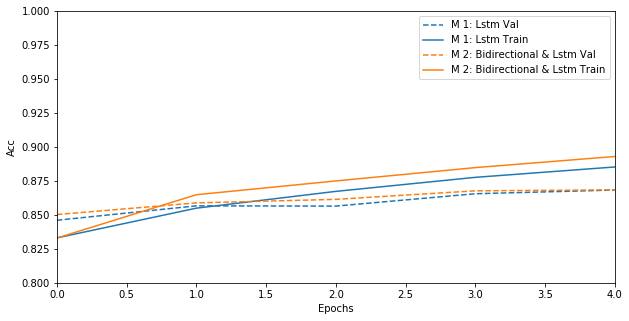

In [89]:
def plot_history(histories, key='acc'):
  plt.figure(figsize=(10,5))
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])
  plt.ylim([0.8,1])


plot_history([('M 1: LSTM', history),
              ('M 2: Bidirectional & LSTM', history_2)])




## Step 5：Make Predictions

### Using the LSTM Model (Model 1) to make predictions:

In [54]:
#With the model trained, we can use it to make predictions and see how it fit with true value.
predictions = model.predict(x_val)

In [57]:
#Here, the model has predicted the label for each review in the testing set. Let's take a look at a random row prediction:
#A prediction is an array of 3 numbers. These describe the "confidence" of the model that the review on 366th row 
#corresponds to which of the 3 different review feedback. We can see "2" has the highest confidence value 0.9908 and it 
#predicts 2, which means it's positive review.
print (predictions[300])
print (np.argmax(predictions[300]))

[3.3957718e-04 3.4014878e-03 9.9625897e-01]
2


In [95]:
#Let's check row data to see how this review looks like
# On validation we checked the original review, the true value rated as 2(positive), also the actual review seems compliment, 
#Thus, the result same as we predicted
print('Actual Review:\n', new_df.iloc[200300,2], '\n')

print('Actual label: \n',np.argmax(y_val[300]))

Actual Review:
 yummy and affordable chinese food i like to order takeout from ts because you are always full and happy with the food you typically also can get the meal deal which includes egg roll with the entree i like the steamed dumplings  cashew chicken  dining in is also fun if you are in the park rd  area good service 

Actual label: 
 2


In [59]:
#Let's find a negative prediction review, on row 388 we can see the prediction has 90% confidence on 0, 
#the model predicts its negative rates.
print (predictions[388])
print(np.argmax(predictions[388]))

[0.79312515 0.06544247 0.14143239]
0


In [93]:
#On validation we checked the original review rates same as 0(negative) what we've predicted.
#Also, the actual review seems very bad. The model has pretty high accuracy.
print('Actual Review:\n',new_df.iloc[200388,2],'\n')

print('Actual label: \n',np.argmax(y_val[388]))

Actual Review:
 dont bother take a lighter and burn your money right in front of you and you will have more fun than giving it to this guy he spends most of the time promoting his dvd and resume my  year old son was in shock when the show finished thats it he said what a joke 

Actual label: 
 0


## Step 6: Create Alternative Models

### Alternative Model #1: CNN 

In [82]:
dropout_rate=0.3
model_3 = keras.Sequential()
model_3.add(keras.layers.Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_3.add(keras.layers.Dropout(dropout_rate))
model_3.add(keras.layers.Conv1D(128,kernel_size=4, strides=1, padding='same'))
model_3.add(keras.layers.MaxPooling1D (pool_size=2))
model_3.add(keras.layers.Flatten())
model_3.add(keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.1), activation=tf.nn.relu))
model_3.add(keras.layers.Dense(3, activation=tf.nn.softmax))

model_3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 256, 50)           500000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256, 50)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 256, 128)          25728     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 128, 128)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                1048640   
_________________________________________________________________
dense_6 (Dense)              (None, 3)                

In [83]:
# Compile the model
model_3.compile(optimizer=tf.train.AdamOptimizer(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [84]:
# Train the model
history_3 = model_3.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=128, epochs=5, verbose=1)
                    

Train on 200000 samples, validate on 50000 samples
Epoch 1/5
200000/200000 [==============================] - 187s 937us/sample - loss: 0.5901 - acc: 0.8254 - val_loss: 0.4976 - val_acc: 0.8426
Epoch 2/5
200000/200000 [==============================] - 190s 951us/sample - loss: 0.4554 - acc: 0.8522 - val_loss: 0.4516 - val_acc: 0.8471
Epoch 3/5
200000/200000 [==============================] - 190s 951us/sample - loss: 0.4208 - acc: 0.8606 - val_loss: 0.4369 - val_acc: 0.8547
Epoch 4/5
200000/200000 [==============================] - 191s 955us/sample - loss: 0.4077 - acc: 0.8651 - val_loss: 0.4433 - val_acc: 0.8511
Epoch 5/5
200000/200000 [==============================] - 191s 955us/sample - loss: 0.3996 - acc: 0.8680 - val_loss: 0.4327 - val_acc: 0.8547


In [86]:
# Save the model
model_3.save('M3.h5')

W0723 23:49:53.236206  9160 hdf5_format.py:110] TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file. You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).


### Alternative Model 2: LSTM and CNN

In [37]:
dropout_rate=0.3
model_4 = keras.Sequential()
model_4.add(keras.layers.Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_4.add(keras.layers.Dropout(dropout_rate))
model_4.add(keras.layers.Conv1D(128,kernel_size=5, strides=1, padding='same'))
model_4.add(keras.layers.MaxPooling1D (pool_size=2))
model_4.add(keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model_4.add(keras.layers.Dense(3, activation=tf.nn.softmax))

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 256, 50)           500000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256, 50)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 128)          32128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 128, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 664,099
Trainable params: 664,099
Non-trainable params: 0
________________________________________________

In [38]:
# Compile the model
model_4.compile(optimizer=tf.train.AdamOptimizer(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
# Train the model
history_4 = model_4.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=128, epochs=5, verbose=1)

Train on 200000 samples, validate on 50000 samples
Epoch 1/5
200000/200000 [==============================] - 1482s 7ms/sample - loss: 0.4243 - acc: 0.8369 - val_loss: 0.3506 - val_acc: 0.8625
Epoch 2/5
200000/200000 [==============================] - 1450s 7ms/sample - loss: 0.3278 - acc: 0.8706 - val_loss: 0.3313 - val_acc: 0.8681
Epoch 3/5
200000/200000 [==============================] - 1447s 7ms/sample - loss: 0.3001 - acc: 0.8815 - val_loss: 0.3305 - val_acc: 0.8713
Epoch 4/5
200000/200000 [==============================] - 1493s 7ms/sample - loss: 0.2804 - acc: 0.8892 - val_loss: 0.3278 - val_acc: 0.8723
Epoch 5/5
200000/200000 [==============================] - 1449s 7ms/sample - loss: 0.2644 - acc: 0.8957 - val_loss: 0.3353 - val_acc: 0.8710


In [40]:
# Save the model
model_4.save('M4.h5')

W0722 21:21:50.231292  9160 hdf5_format.py:110] TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file. You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).


## Step 6: Plot Results of Alternative Models

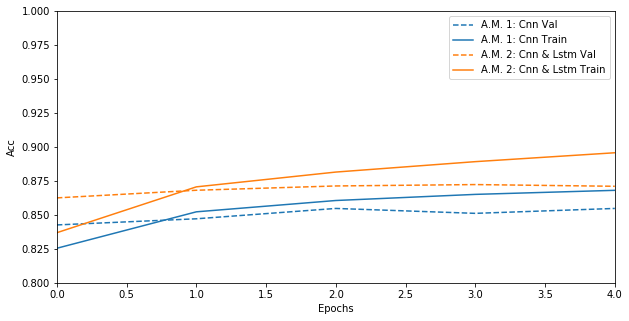

In [91]:
def plot_history(histories, key='acc'):
  plt.figure(figsize=(10,5))
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])
  plt.ylim([0.8,1])


plot_history([('A.M. 1: CNN', history_3),
              ('A.M. 2: CNN & LSTM', history_4)])